In [16]:
!pip install matplotlib
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import pickle
import os

samples_per_ramp: 17785
channel_number: 0
ramp_number: 21900
ramp_type: 2
sdr_angle: 3.141340494155884
roll_angle: 0.0
pitch_angle: 0.0
yaw_angle: 0.0
sdr_steps_per_rotation: 6.2831854820251465
sdr_motor_state: 0
ramp_start_freq: 72003108864.0
ramp_end_freq: 81996890112.0
ramp_up_time: 0.0017785000381991267
ramp_down_time: 0.0
sample_rate: 10000000
ramp_timestamp: 236763916800
data_scaling: 32768.0
sensor_statue: 0
sync_measurement_tag: 0
bandwidth: 9993781248.0
slope: 5619219023531.481
fft_size: 65536
index_to_m: 0.004070378694969872
max_distance: 133.37816907677276
samples_per_ramp: 17785
channel_number: 0
ramp_number: 10799
ramp_type: 2
sdr_angle: 3.141340494155884
roll_angle: 0.0
pitch_angle: 0.0
yaw_angle: 0.0
sdr_steps_per_rotation: 6.2831854820251465
sdr_motor_state: 0
ramp_start_freq: 72003108864.0
ramp_end_freq: 81996890112.0
ramp_up_time: 0.0017785000381991267
ramp_down_time: 0.0
sample_rate: 10000000
ramp_timestamp: 132441221800
data_scaling: 32768.0
sensor_statue: 0
sync_me

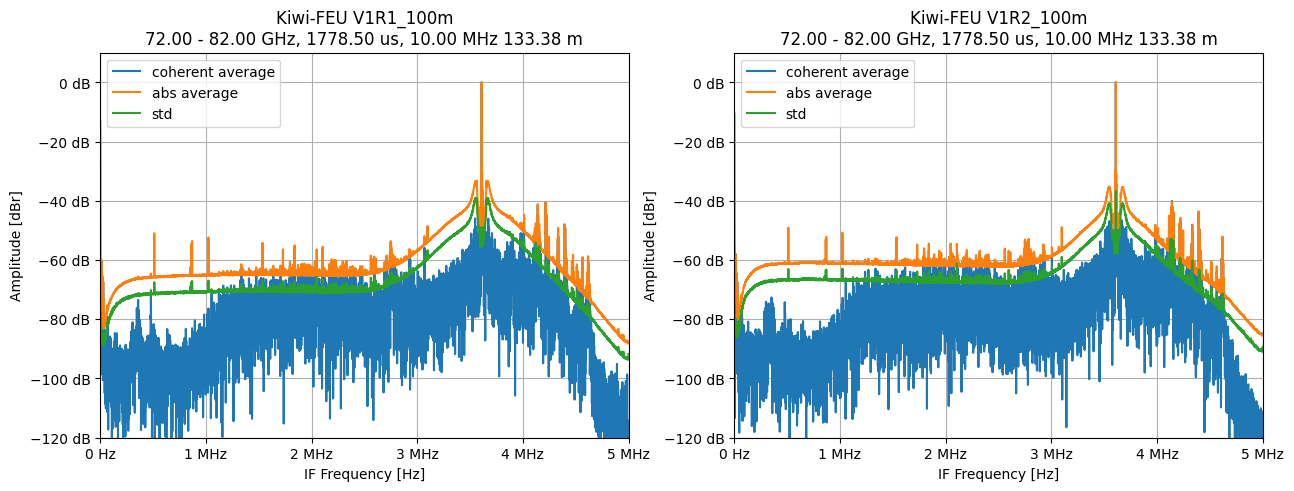

In [33]:
log_path = './pkl'

files = os.listdir(log_path)
# filter .pkl files
files = [file for file in files if file.endswith('.pkl')]

fig, axs = plt.subplots(1, len(files), figsize=(15, 5)) 
if len(files) == 1:
    axs = [axs]

# header example: {'samples_per_ramp': 17785, 'channel_number': 0, 'ramp_number': 21900, 'ramp_type': 2, 'sdr_angle': 3.141340494155884, 
# 'roll_angle': 0.0, 'pitch_angle': 0.0, 'yaw_angle': 0.0, 'sdr_steps_per_rotation': 6.2831854820251465, 'sdr_motor_state': 0, 
# 'ramp_start_freq': 72003108864.0, 'ramp_end_freq': 81996890112.0, 'ramp_up_time': 0.0017785000381991267, 'ramp_down_time': 0.0,
#  'sample_rate': 10000000, 'ramp_timestamp': 236763916800, 'data_scaling': 32768.0, 'sensor_statue': 0, 'sync_measurement_tag': 0}

light_speed = 299792458 
# def get_index_to_m(header):
#     Fs = header['adc_sample_rate']
#     t = header['ramp_up_time']
#     BW = header['end_frequency'] - header['start_frequency']
#     return (Fs * t * light_speed) / (header['fft_size'] * BW * 2)

for i, file in enumerate(files):
    with open(os.path.join(log_path, file), 'rb') as f:
        header, data, _ = pickle.load(f)

        header['bandwidth'] = header['ramp_end_freq'] - header['ramp_start_freq']
        header['slope'] =(header['bandwidth'] / header['ramp_up_time'])
        header['fft_size'] = 2**16
        header['index_to_m'] = (header['sample_rate'] * header['ramp_up_time'] * light_speed) / (header['fft_size'] * header['bandwidth'] * 2)
        header['max_distance'] = header['index_to_m'] * header['fft_size'] / 2
         
        for key, value in header.items():
            print(f'{key}: {value}')

        window = np.hanning(data.shape[1])
        window = window / np.sum(window) / 2**15
        data = data * window 
        data_fft = np.fft.fft(data, n=header['fft_size'], axis=1)[:,:header['fft_size']//2]

        data_mean_coh = np.abs(np.mean(data_fft, axis=0))
        data_mean_abs = np.mean(np.abs(data_fft), axis=0)
        data_std = np.std(np.abs(data_fft), axis=0)
        
        data_mean_coh /= np.max(data_mean_coh)
        data_std /= np.max(data_mean_abs)
        data_mean_abs /= np.max(data_mean_abs)
        
        distance = np.linspace(0, header['max_distance'], header['fft_size']//2)
        frequency = 2 * distance * header['slope'] / light_speed

        name = file.split('.')[0]
        settings = f"{header['ramp_start_freq']/1e9:.2f} - {header['ramp_end_freq']/1e9:.2f} GHz, {header['ramp_up_time']*1e6:.2f} us, {header['sample_rate']/1e6:.2f} MHz {header['max_distance']:.2f} m"

        axs[i].plot(frequency, 20*np.log10(data_mean_coh), label='coherent average')
        axs[i].plot(frequency, 20*np.log10(data_mean_abs), label='abs average')
        axs[i].plot(frequency, 20*np.log10(data_std), label='std')
        axs[i].legend()
        axs[i].set_title(f'{name}\n{settings}')
        axs[i].set_xlabel('IF Frequency [Hz]')
        axs[i].set_ylabel('Amplitude [dBr]') 
        axs[i].grid(True) 
        axs[i].grid(True, which='minor', linestyle='--', alpha=0.5) 
        axs[i].xaxis.set_major_formatter(EngFormatter(unit='Hz'))
        axs[i].yaxis.set_major_formatter(EngFormatter(unit='dB'))
        axs[i].set_xlim([0, 5e6])
        axs[i].set_ylim([-120, 10])
        

